# 離散フーリエ変換について

## 概要

データ分析の文脈では、離散フーリエ変換はデータ確認や特徴量作成でしばしば用いられる。
- 1. 時系列分析で周期の有無を確認する際は、離散フーリエ変換を用いて確認することが多い。  
- 2. クラスタリングのための特徴量として、時系列で変化する値を離散フーリエ変換した値を特徴量に使うことがある。
- 3. (まれに)系列のスムージングを行うときに、離散フーリエ変換を用いることがある

フーリエ変換には連続フーリエ変換もあるが、コンピュータで作業する上では、離散フーリエ変換を抑えておけばまず問題ない。

離散フーリエ変換の考え方としては、ある数列$f_{t}$は、複数の正弦波(サインカーブ)の線形和(係数$F_{\omega}$をかけて、足し合わせたもの)で書ける、というアイデアである。

$$f_{t}= \frac{1}{N}\sum_{\omega=0}^{N-1} F_{\omega} e^{i2\pi \frac{\omega}{N} t}$$

ここで$N$はデータのレコード数、$e^{i2\pi \frac{\omega}{N} t}$は周波数が$\frac{\omega}{N}$の正弦波(サインカーブ)を複素数で表現したものである。わざわざ複素数で表現している理由としては、「複素数で表現したほうが計算が楽になるので、複素数で表現している」という理解で問題ない。  
**離散フーリエ変換とは、正弦波の足し合わせのための係数$F_{\omega}$を求めるための計算に他ならない**。離散フーリエ変換は、なんらかの数列$f_{t}$を正弦波に分解するための変換とも言える。  

変換式は以下のとおり。

$$F_{\omega}= \sum_{t=0}^{N-1} f_{t} e^{-i2\pi \frac{\omega}{N}t}$$

つまり、なんらかの数列$f_{t}$(例えば月次ワランティ推移)の各値に対して、周波数が$\frac{\omega}{N}$の複素正弦波$e^{-i2\pi \frac{\omega}{N}t}$をそれぞれ掛けて足し算してあげれば、周波数$\omega$の正弦波に対する係数$F_{\omega}$が計算できる。

また、最初に出てきた、正弦波を足し合わせて数列を表現する式を、**逆離散フーリエ変換**と呼ぶ。(以下再掲)

$$f_{t}= \frac{1}{N}\sum_{\omega=0}^{N-1} F_{\omega} e^{i2\pi \frac{\omega}{N} t}$$

numpyには、上記のフーリエ変換を効率的に計算するアルゴリズムである、高速フーリエ変換(FFT; Fast Fourier Transform)が実装されている。以下ではこれを用いる。

In [1]:
# 足し合わせの実験
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# 日経平均を正弦波の足し合わせで表現する
nikkei = pd.read_csv("../data/raw/nikkei_stock_average_daily_jp.csv", encoding="shift-jis", delimiter=",")

In [2]:
nikkei = pd.Series(nikkei.iloc[:-1,2].values, index=nikkei.iloc[:-1,0].values,
                   name="close")

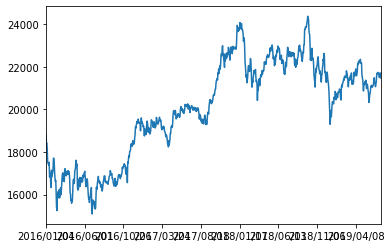

In [3]:
nikkei.plot();

In [4]:
# 正弦波の足し合わせのための係数 4つ分
coef = [2.00330291e+04, 2.90849497e+03, 6.60972063e+02, 6.73262359e+02]

# 位相の調整(実数のコサインカーブで足し合わせようとしているため。複素正弦波を使用するときは必要なし)
angle = [ 0.        ,  2.02020571,  1.61121312,  1.13601843, -0.10670583]

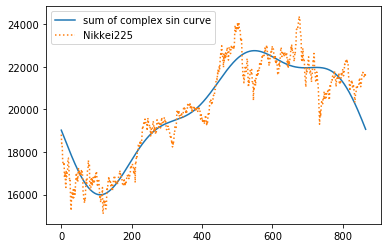

In [5]:
N = len(nikkei)
t = np.arange(N)
s = np.zeros(N)
for i,(c,a) in enumerate(zip(coef,angle)):
    s += c * np.cos(2*np.pi*i/N*t+a) # 整数倍の周波数の正弦波を、係数を掛けてから足し合わせる。

plt.plot(s, label="sum of complex sin curve")
plt.plot(nikkei.values, ":", label="Nikkei225")
plt.legend()

## numpyを用いた計算

### フーリエ変換

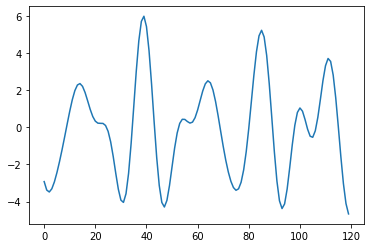

In [6]:
x = np.linspace(0,119,120) # 0, ,1, ..., 120
# 周期12(周波数0.833..)の波と、周期15(周波数0.066..)の波と、周期23(周波数0.435..)の波の合成
sample = (np.sin(2 * np.pi * x / 12) 
          + 2 * np.sin(2 * np.pi * (x - 5)/ 15)
          + 3 * np.sin(2 * np.pi * (x - 10)/ 23)) 
plt.plot(sample)

(**蛇足**)ハニング窓など、両端を減衰させる窓関数をかけると、データの両端が不連続であることからが生じる不要な高周波成分を除去できることがある。ハニング窓のかけ方は以下。

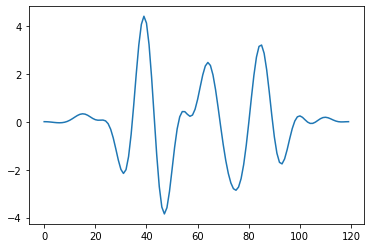

In [7]:
sample_hanning = sample * np.hanning(len(sample))
plt.plot(sample_hanning);

フーリエ変換をかけてみる

In [8]:
fft_sample = np.fft.fft(sample)
fft_sample[:10]

array([ -11.35916586 +0.j        ,  -11.82850206 +1.27647805j,
        -13.4790549  +2.88080941j,  -17.43779063 +5.50070479j,
        -28.9069993 +11.89050883j, -149.87611336+74.93262773j,
         39.10872696-22.69341266j,   16.33036886-10.64010442j,
        -93.86604407+52.82429714j,    7.17784999 -5.49899388j])

式に複素数を含むことから分かるように、フーリエ変換結果は複素数である(numpyでは、~~ + ~~ **j**の形で表示される)

In [9]:
# ちなみにnp.complexなどで複素数を作ることができる
np.complex(3, 0.5)

(3+0.5j)

複素数の絶対値をプロットしてみる(複素数の絶対値は、$\sqrt{(Real)^2 + (Img)^2}$)

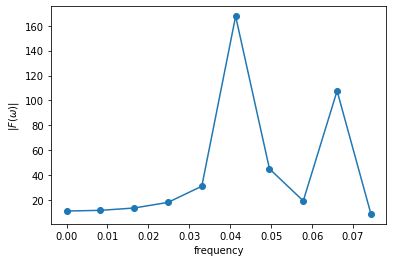

In [10]:
plt.plot(1/121 * np.arange(10), abs(fft_sample[:10]), "-o")
plt.xlabel("frequency")
plt.ylabel("$|F(\omega)|$");

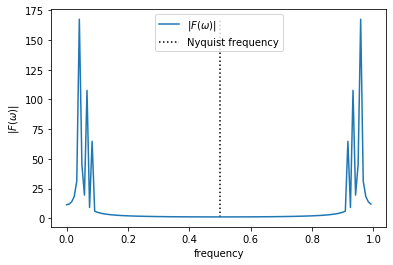

In [11]:
plt.plot(1/len(fft_sample) * np.arange(len(fft_sample)), abs(fft_sample), label="$|F(\omega)|$")
plt.xlabel("frequency")
plt.ylabel("$|F(\omega)|$")
plt.vlines(0.5, min(abs(fft_sample)), max(abs(fft_sample)), linestyle=":",label="Nyquist frequency")
plt.legend();

左右対称の形となっているが、右半分は**折返し雑音(エイリアシング)**と呼ばれる。  
左半分のみを対称とする。  

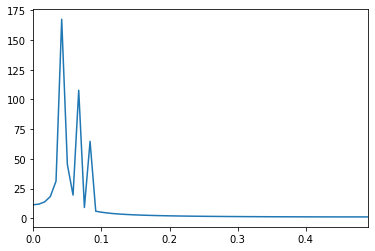

In [12]:
# 半分だけを使用する
fft_sample_sub = pd.Series(abs(fft_sample)[:len(fft_sample)//2], 
                           index=1/len(fft_sample) * np.arange(len(fft_sample)//2))
fft_sample_sub.plot();

- ちなみに、サンプリング周波数(今回であれば1)の半分の周波数をナイキスト周波数といい、ナイキスト周波数以上の高周波は正確に検出できない。例えばCD音源は44kHzのサンプリング周波数が良く用いられるが、これは人間の聞こえる音の周波数がおおよそ20kHzまでであり(それ以上は超音波)、そこまでの高さの音を検出するため、約2倍+αの44kHzが採用されている
    - さらにちなみに、高速で回転するホイールなどがゆっくりと回転しているように見えるストロボ効果も、折返し雑音(エイリアシング)の一種である。これは人間の目のサンプリング周波数の半分以上の周波数(回転数)でホイールが回転しているために発生する。

- 下図では、低周波(赤線)と高周波(青線)は、サンプリング点(黒丸)で完全に同じ値を取る。黒丸の周波数25のサンプリングでは、周波数の高い黒線(周波数20)は周波数の低い赤線(周波数5)と区別して検出することができないのである。  

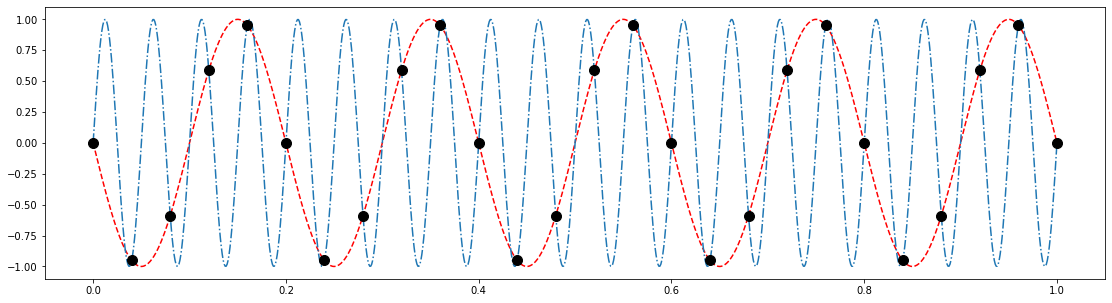

In [13]:
x = np.linspace(0,1,1001)
high_freq = np.sin(2 * np.pi * x * 20)
low_freq = np.sin(2 * np.pi * -x * 5)
plt.figure(figsize=(19,5))
plt.plot(x, low_freq, "r--")
plt.plot(x, high_freq, "-.")

x_sampled = x[::1000//25]
high_freq_sampled = high_freq[::1000//25]
plt.plot(x_sampled, high_freq_sampled , "ko", markersize=10);

サンプリング周波数$f_{sample}$とある周波数$f_{target}$とエイリアスの周波数$f_{low}$は以下の関係にある。ただしNは1以上の整数。
$$f_{alias} = | f_{target} - N f_{sample}|$$
(上の例は$N$が1、$f_{alias}$が20、$f_{target}$が5、$f_{sample}$が25の例といえる)

### パワースペクトル

フーリエ変換後の関数の絶対値の二乗を興味の対象とすることが多い。フーリエ変換後の関数を二乗した値は、**パワースペクトル**と呼ばれる。  
(二乗せずに、絶対値だけ取る分析者もいる。絶対値は振幅を意味しており、**振幅スペクトル**と呼ばれる)

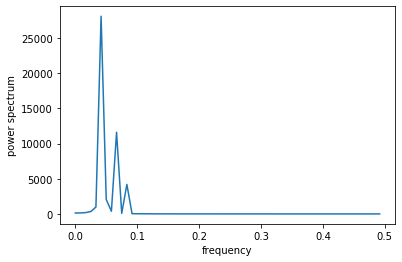

In [14]:
pp_sample_sub = abs(fft_sample_sub)**2
plt.plot(pp_sample_sub)
plt.xlabel("frequency")
plt.ylabel("power spectrum");

上記のような、縦軸にパワースペクトル、横軸に周波数を取ったグラフを、**ピリオドグラム**と呼ぶ

パワースペクトルの対数を取ったものは、(そのままだが)**対数パワースペクトル**と呼ばれる。

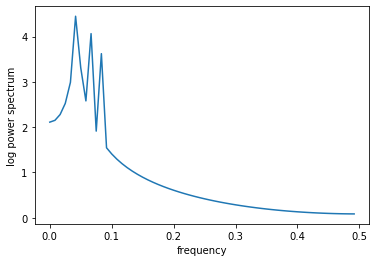

In [15]:
pp_sample_sub = np.log10(abs(fft_sample_sub)**2)
plt.plot(pp_sample_sub)
plt.xlabel("frequency")
plt.ylabel("log power spectrum");

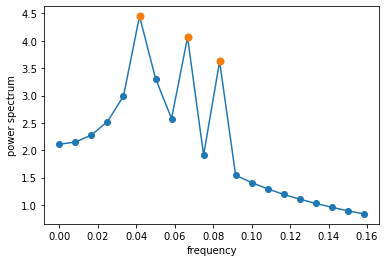

In [16]:
from scipy.signal import find_peaks

ix_peak,_ = find_peaks(pp_sample_sub[:20])
plt.plot(pp_sample_sub.iloc[:20], "o-")
plt.plot(pp_sample_sub.iloc[ix_peak], "o", markersize=7)
plt.xlabel("frequency")
plt.ylabel("power spectrum");

In [17]:
find_peaks(pp_sample_sub)

(array([ 5,  8, 10]), {})

周波数0.833..(周期12$\pi$)、周波数0.066..(周期15$\pi$)、周波数0.435..(周期23$\pi$)近辺にピークがあることがわかる。  
周波数ではなく周期を横軸にプロットするとわかりやすい。

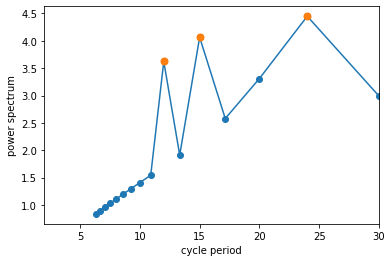

In [18]:
plt.plot(1/pp_sample_sub.iloc[:20].index, pp_sample_sub.iloc[:20], "o-")
plt.plot(1/pp_sample_sub.iloc[ix_peak].index, 
         pp_sample_sub.iloc[ix_peak].values, "o", markersize=7)
plt.xlabel("cycle period")
plt.ylabel("power spectrum")
plt.xlim(2,30);

## ケース1. 周期の確認

In [19]:
from pathlib import Path
PATH_DATA_INTERIM = Path("../data/interim/")
df_warranty_model_part_num_daily = pd.read_feather(PATH_DATA_INTERIM/"df_warranty_model_part_num_daily.feather")

/Users/localadmin/anaconda3/envs/suzuki/lib/python3.6/site-packages/pyarrow/pandas_compat.py:752: FutureWarning: .labels was deprecated in version 0.24.0. Use .codes instead.
  labels, = index.labels


In [20]:
part_1 = "84702-70K"
ts_tmp_1 = (df_warranty_model_part_num_daily
              .loc[df_warranty_model_part_num_daily.part_cd == part_1,
                          ["date", "n"]]
              .groupby("date")["n"]
              .sum())
ts_tmp_1.index = pd.to_datetime(ts_tmp_1.index)
ts_tmp_1 = ts_tmp_1.resample("MS").sum()

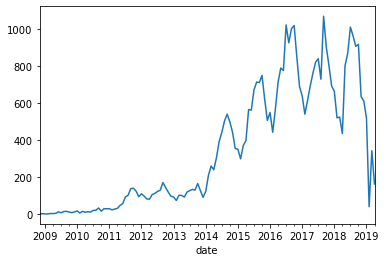

In [21]:
ts_tmp_1.plot()

In [22]:
def calc_ps(series):
    N = len(series)
    return pd.Series(abs(np.fft.fft(series))**2, index=1/N * np.arange(N))

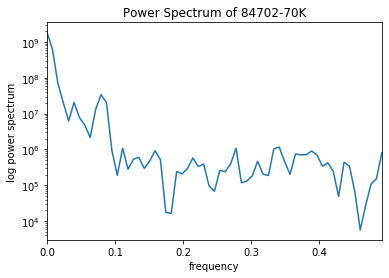

In [23]:
# ピリオドグラムを表示
ps_1 = calc_ps(ts_tmp_1).iloc[:len(ts_tmp_1)//2]
ps_1.plot()
plt.xlabel("frequency")
plt.ylabel("log power spectrum")
plt.title(f"Power Spectrum of {part_1}")
plt.semilogy();

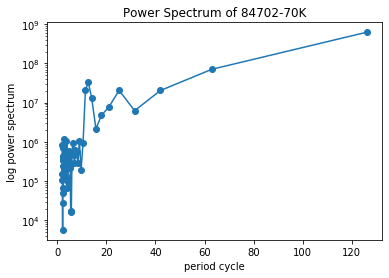

In [24]:
# 周期をx軸に
plt.plot(1/ps_1.index, ps_1.values, "o-")
plt.semilogy()
plt.xlabel("period cycle")
plt.ylabel("log power spectrum")
plt.title(f"Power Spectrum of {part_1}");

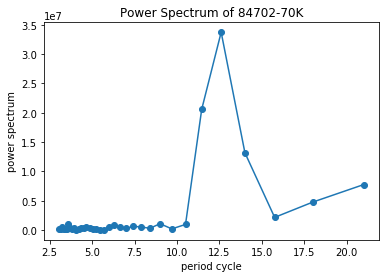

In [25]:
# 周期3(周波数0.33) ~ 周期24(周波数0.041) までを確認
ps_1_sub = ps_1.iloc[np.where((ps_1.index > 0.041) & (ps_1.index < 0.33))]
plt.plot(1/ps_1_sub.index, ps_1_sub.values, "o-")
plt.xlabel("period cycle")
plt.ylabel("power spectrum")
plt.title(f"Power Spectrum of {part_1}");

In [26]:
# パーツ"27610-76G"のピークを確認してみましょう

## ケース2. 特徴量の作成

In [27]:
# 科目2で作成したデータを使用
from pathlib import Path
import pickle

PATH_DATA_PRO_SUB2_PKL = Path("../data/processed/subject02/pickle")

for k in ["lsNpCanResampled", "lsNamesFeatureMultiVal",
         "timeSeriesStart2End", "pdFeatureProfile"]:
    with open(PATH_DATA_PRO_SUB2_PKL/(k + ".pkl"), "rb") as f:
        data = pickle.load(f)
    exec(k + "=data")

In [28]:
pdFeatureProfile.head(3)

,feature,key,featureName,featureName2,isinThisFile,isMultiValOf104,maxAbsPAC,isRemoveDueToPAC
0,0FA21,sc0FA21,NaN,No_Name,1,0,NaN,0
1,0FA22,sc0FA22,NaN,No_Name,1,0,NaN,0
2,0FA23,sc0FA23,NaN,No_Name,1,0,NaN,0


In [29]:
resampled_CAN = pd.DataFrame({col:val for col, val 
                                in zip(lsNamesFeatureMultiVal, lsNpCanResampled)},
                              index = timeSeriesStart2End)
feature_name_dict = {code: "xxx" + code if pd.isna(name) else name for _, (code, name)
                     in pdFeatureProfile[["feature","featureName"]].iterrows()}
resampled_CAN.rename(columns=feature_name_dict, inplace=True)
resampled_CAN = resampled_CAN.loc[:,sorted(resampled_CAN.columns)]

In [30]:
resampled_CAN.head()

,Acceleration Sensor Value,Accelerator Actual Position,Brake Pedal Switch Active,Engine Coolant Temperature,Engine Speed,Engine Torque Actual,Fuel Consumption,Fuel Level Actual Percent,Fuel Level Percent Average,Lateral Sensor Value,...,xxx3D052,xxx3D055,xxx3D064,xxx3D151,xxx3D157,xxx3D604,xxx3D667,xxx3E206,xxx3E801,xxx50007
0.01,0.0,0.0,1.0,49.0,919.0,0.0,0.59,92.156863,92.156863,0.0,...,0.0,1.0,1.0,1.3,1.0,0.0,5.0,1.0,36.55914,8.431021e+18
0.02,0.0,0.0,1.0,49.0,919.0,0.0,0.59,92.156863,92.156863,0.0,...,0.0,1.0,1.0,1.3,1.0,0.0,5.0,1.0,36.55914,8.431021e+18
0.03,0.0,0.0,1.0,49.0,919.0,0.0,0.59,92.156863,92.156863,0.0,...,0.0,1.0,1.0,1.3,1.0,0.0,5.0,1.0,36.55914,8.431021e+18
0.04,0.0,0.0,1.0,49.0,919.0,0.0,0.59,92.156863,92.156863,0.0,...,0.0,1.0,1.0,1.3,1.0,0.0,5.0,1.0,36.55914,8.431021e+18
0.05,0.0,0.0,1.0,49.0,919.0,0.0,0.59,92.156863,92.156863,0.0,...,0.0,1.0,1.0,1.3,1.0,0.0,5.0,1.0,36.55914,8.431021e+18


In [31]:
col_with_name = [col for col in resampled_CAN.columns if not col.startswith("xxx")]
len(col_with_name)

23

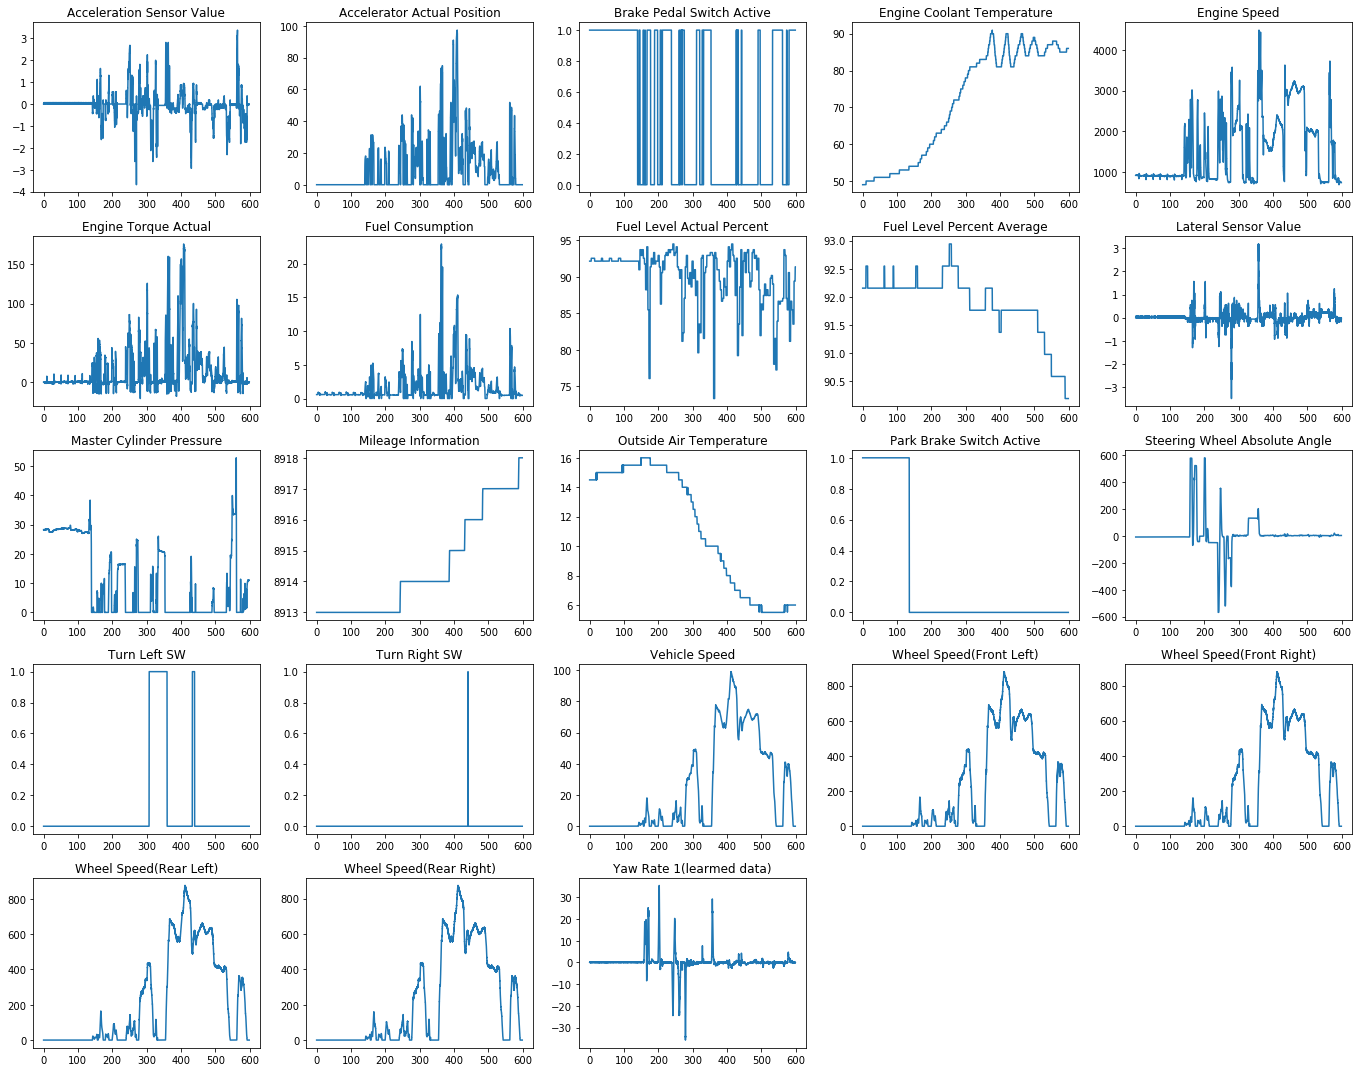

In [32]:
fig = plt.figure(figsize=(19,15))

for i, col in enumerate(col_with_name):
    ax = fig.add_subplot(5, 5, i+1)
    ax.plot(resampled_CAN[col])
    ax.set_title(col)
    
plt.tight_layout()

In [33]:
# スペクトル包絡(スペクトルをなめらかにしたもの)を計算する関数。原理は後述のケース3. スムージングと一緒。
def calc_ceps(series, cutOffCeps):
    N = len(series)
    fft = pd.Series(np.fft.fft(series), index=1/N * np.arange(N))
    fft[N//2:] = 0 # ナイキスト周波数以降を0に
    fft.iloc[1:len(fft//2)] = fft.iloc[1:len(fft//2)]*2 # 振幅を2倍に(エイリアシングによって、半分に分かれてしまうので)
    
    # 指定した周波数以上の振幅を0に
    fft[fft.index > cutOffCeps] = 0
    
    # np.realによって、複素数の虚数部分を落とす
    return pd.Series(np.real(np.fft.ifft(fft)), index=series.index)

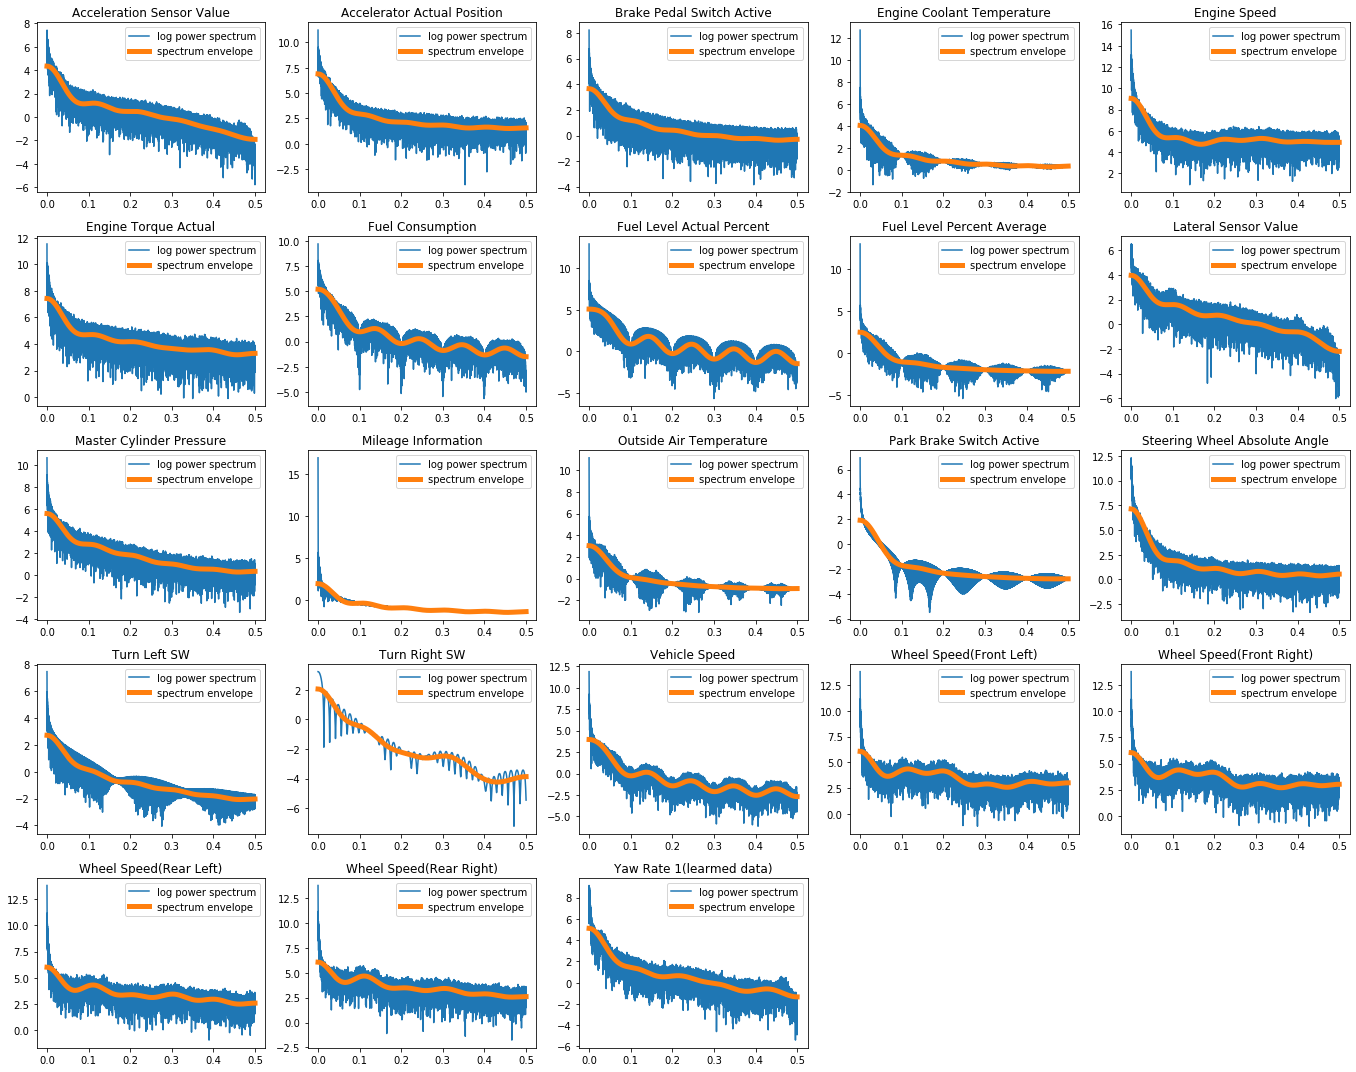

In [34]:
fig = plt.figure(figsize=(19,15))

for i, col in enumerate(col_with_name):
    series = resampled_CAN[col] * np.hamming(len(resampled_CAN[col]))
    N = len(series)
    ax = fig.add_subplot(5, 5, i+1)
    log_spec= np.log10(calc_ps(series))
    ceps = calc_ceps(log_spec, 1/N * 10)
    ax.plot(log_spec.iloc[:N//2], label="log power spectrum")
    ax.plot(ceps.iloc[:N//2], lw=5, label="spectrum envelope")
    ax.set_title(col)
    plt.legend()
    
plt.tight_layout()

※上記の例では全期間を使用してしまっているので、興味のあるアクションの部分のみのデータ("加速時"など)を取り出すか、使用するデータをスライドさせながら時系列としてフーリエ変換を行い(**短時間フーリエ変換**と呼ぶ)、その時系列を特徴量として用いることが望ましい

例えば[この論文](https://www.google.com/url?sa=t&rct=j&q=&esrc=s&source=web&cd=1&ved=2ahUKEwiOwN3gm7zjAhV5KqYKHXL1Dc4QFjAAegQIAhAC&url=https%3A%2F%2Fnagoya.repo.nii.ac.jp%2F%3Faction%3Drepository_action_common_download%26item_id%3D7901%26item_no%3D1%26attribute_id%3D17%26file_no%3D1&usg=AOvVaw2vu9QGVmq7mEXrgoDeknKJ)では、運転者の識別モデルの特徴量として、アクセル時などのデータのスペクトル包絡(正確には、スペクトル包絡をフーリエ変換したときの係数)も用いている。

## ケース3. スムージング

In [35]:
ts_tmp_2 = (df_warranty_model_part_num_daily
              .loc[df_warranty_model_part_num_daily.part_cd == "37950-58J",
                          ["date", "n"]]
              .groupby("date")["n"]
              .sum())
ts_tmp_2.index = pd.to_datetime(ts_tmp_2.index)
ts_tmp_2 = ts_tmp_2.resample("MS").sum()

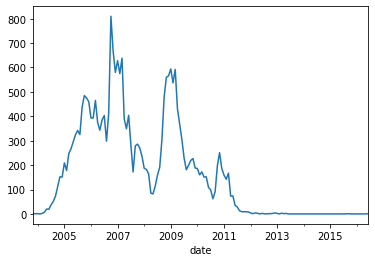

In [36]:
ts_tmp_2.plot();

注意点としては、ナイキスト周波数以上を0にした後、逆フーリエ変換に元に戻す前に、振幅を2倍にしてあげる必要がある。  
これは、ナイキスト周波数を挟んで対称になっていた成分をごっそり落としてしまうので、その補正である。

In [37]:
def cutHighFreq(series, max_freq):
    N = len(series)
    fft = pd.Series(np.fft.fft(series), index=1/N * np.arange(N))
    fft[N//2:] = 0 # ナイキスト周波数以降を0に
    fft.iloc[1:len(fft//2)] = fft.iloc[1:len(fft//2)]*2 # 振幅を2倍に(エイリアシングによって、半分に分かれてしまうので)
    
    # 指定した周波数以上の振幅を0に
    fft[fft.index > max_freq] = 0
    
    # np.realによって、複素数の虚数部分を落とす
    return pd.Series(np.real(np.fft.ifft(fft)), index=series.index)

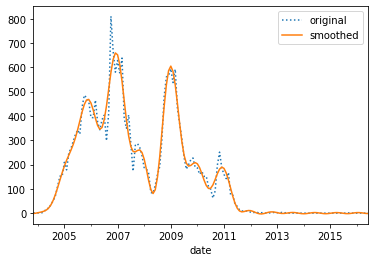

In [38]:
ax = plt.subplot(1,1,1)
ts_tmp_2.plot(ax=ax, style=":", label="original")
cutHighFreq(ts_tmp_2, 1/10).plot(ax=ax, label="smoothed") # 周波数>0.1(周期<10)をカット
plt.legend()

In [39]:
# 自由にパーツを選び、スムージングしてみましょう

## 宿題

- notebookの冒頭を参考にして、周期5(周波数0.2)の波の時系列データを作成し、ペリオドグラムを描画し、確かに周期を検出できているか確認しましょう。
- 太陽黒点データについて、ペリオドグラムを描画し、周期について考察しましょう
- スムージングの例について、逆に高周波のみを残すような関数cutLowFreqを作成し、自由にパーツを選び、適用してみましょう。また、この関数はどのような用途に使えるか、考えてみましょう。

In [40]:
# 太陽黒点データ
import statsmodels.api as sm

sunspots = sm.datasets.sunspots.load_pandas().data

In [41]:
sunspots = sunspots.set_index("YEAR")["SUNACTIVITY"]

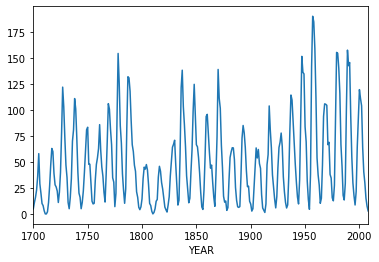

In [42]:
sunspots.plot()